In [1]:
import numpy as np
import lDGA.config as cfg
import lDGA.dmft_reader as dmft_reader
import lDGA.bse as bse
import lDGA.utilities as util
import matplotlib.pyplot as plt

### load dmft data

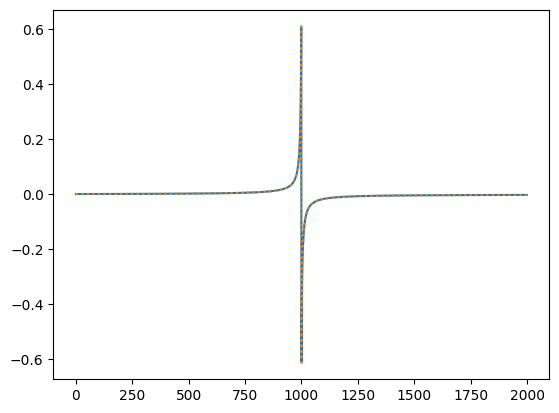

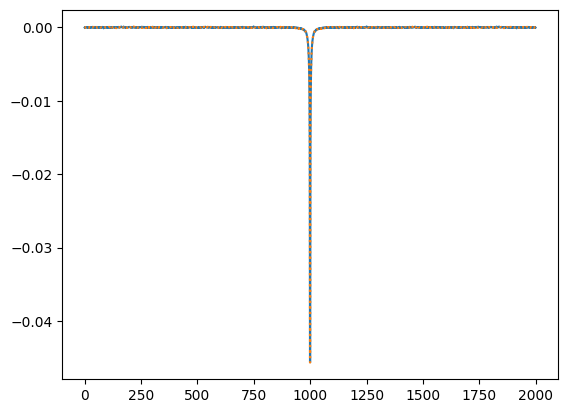

In [5]:
# example file
dmft_file = "gsq0_0_w1_n0_95_2p-2025-03-22-Sat-17-25-49.hdf5"

dga_cfg = cfg.DGA_Config(dmft_file)
reader = dmft_reader.DMFT_Reader(dga_cfg)

beta = dga_cfg.dmft_dict['beta']
mu = dga_cfg.dmft_dict['mu']
U = dga_cfg.dmft_dict['U']
g = dga_cfg.dmft_dict['giw']
s = dga_cfg.dmft_dict['siw']
g2 = dga_cfg.dmft_dict['chi_ph']
niwf = dga_cfg.niwf
n4iwf = dga_cfg.n4iwf
n4iwb = dga_cfg.n4iwb
kdim = dga_cfg.kdim
nk = 96

In [12]:
g0 = dga_cfg.dmft_dict['g0']
w0 = dga_cfg.dmft_dict['w0']
n = dga_cfg.dmft_dict['occ']

n*2

np.float64(0.9504318658627897)

### calculate lattice chi_q

In [33]:
chi0_w = bse.chi0_loc_w(beta, g, n4iwf, n4iwb)

# kgrid has to be initialized beforehand
kpoints = np.linspace(-np.pi,np.pi,96,endpoint=False)
k_grid = np.meshgrid(kpoints,kpoints)
k_grid = np.array(k_grid).reshape(2,-1).T

chi0_q_w = bse.chi0_q_w(beta, mu, s, k_grid, kdim, 96, np.array([[0.,0.]]), niwf, n4iwf, n4iwb)
print(chi0_q_w.shape)

u = U*np.ones([2*n4iwb+1], dtype=np.float64)
data = bse.chi_v_r_q_w(beta, u, chi0_w, chi0_q_w, g2, n4iwf, n4iwb, qpoints=np.array([[0.,0.]]), nk=96)

(260, 41, 1)


/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


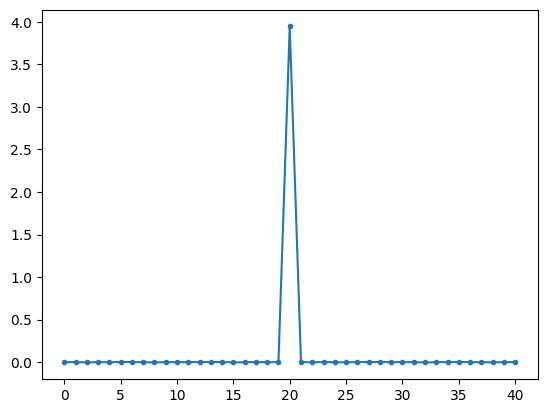

In [34]:
import matplotlib.pyplot as plt

chi = data[0]

plt.plot(chi, ".-")


In [35]:
F_d, F_m = bse.F_r_loc(beta, chi0_w, g2, n4iwf, n4iwb)

print(F_d.shape)

(260, 260, 41)


In [42]:
F_uu = 0.5*(F_d+F_m)

print(F_uu.shape)

F_uu_1 = F_uu[130+72,130+70,5]

F_uu_2 = -F_uu[130+72,130+72,3]

print(F_uu_1, F_uu_2)

(260, 260, 41)
(-3.2809342308280964-19.95673701439307j) (-70.86419608938215-23.3668316656763j)


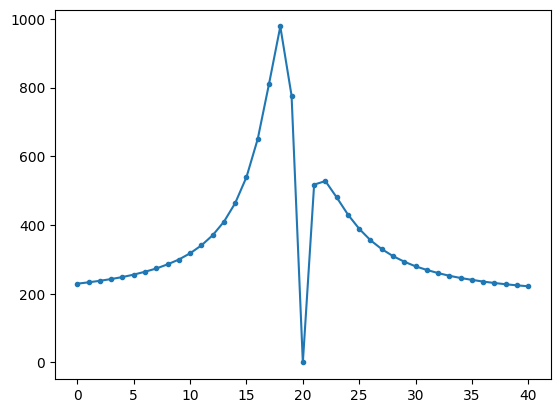

In [43]:
plt.plot(F_uu[130,130, :], ".-")

In [ ]:
chi0 = bse.

(2000,)